In [5]:
import json
import itertools
import random

import torch
import numpy as np
import pandas as pd

In [7]:
TIME_TO_HEAT = 120
TIME_TO_CHANGE_PLACE = 15
NON_SPECIFIC_OPERATIONS = ['nagrev', 'otzhig']

code_dict = {
    'nagrev': 1,
    'otzhig': 2,
    'kovka': 3,
    'prokat': 4,
}

Результатом работы алгритма будет матрица NUM_OVENS x 1440,
обозначающая что делает каждая печь в каждую минуту дня.\
Элемент матрицы это кортеж (номер детали, код вида занятия)

коды:
<ul>
    <li>0 -- подогрев для детали</li>
    <li>1 -- 'nagrev' детали</li>
    <li>2 -- 'otzhig' детали</li>
    <li>3 -- 'kovka' детали</li>
    <li>4 -- 'prokat' детали</li>
    <li>5 -- ждёт TIME_TO_CHANGE_PLACE детали</li>
</ul>

In [30]:

def get_time_requared(task):
    total_time = 0
    for action in task['operations']:
        total_time += action['timing']
    return total_time + TIME_TO_CHANGE_PLACE + TIME_TO_HEAT * (len(task['operations']) - 2)


def get_task_operation(task):
    
    operations = set([oper['name'] for oper in task['operations']])
    if 'kovka' in operations:
        return 'kovka'
    elif 'prokat' in operations:
        return 'prokat'
    elif 'otzhig' in operations:
        return 'otzhig'
    else:
        return None
    

def get_index_of_zero_subarray(row, time_requared, availability_matrix):
    
    row_list = availability_matrix[row]
    intervals = [(x[0], len(list(x[1]))) for x in itertools.groupby(row_list)]
    
    starting_minute = 0
    for idx, interval in enumerate(intervals):
        if interval[0] == 0 and interval[1] >= time_requared:
            if idx == 0:
                return starting_minute
            else:
                for i in range(idx):
                    starting_minute += intervals[i][1]
            return starting_minute
    return -1


def get_operation_code(operation):
    return code_dict[operation['name']]


def update_result_matrix(result_matrix, task, task_idx, starting_idx, oven_idx, requared_heating=False):
    
    if requared_heating:
        result_matrix[oven_idx][starting_idx: starting_idx + TIME_TO_HEAT] = [(task_idx, 0)] * TIME_TO_HEAT
        starting_idx += TIME_TO_HEAT
        
    for i, operation in enumerate(task['operations']):
        
        # обрабатываем операцию
        op_code = get_operation_code(operation)
        op_time = operation['timing']
        result_matrix[oven_idx][starting_idx: starting_idx + op_time] = [(task_idx, op_code)] * op_time
        starting_idx += op_time
        
        # добавляем промежуточные манипуляции
        if i < len(task['operations']) - 1:
            if i == 0: # перемещение детали после нагрева
                result_matrix[oven_idx][starting_idx: starting_idx + TIME_TO_CHANGE_PLACE] = [(task_idx, 5)] * TIME_TO_CHANGE_PLACE
                starting_idx += TIME_TO_CHANGE_PLACE
                
            else: # повторный нагрев детали между ковками или прокатами
                result_matrix[oven_idx][starting_idx: starting_idx + TIME_TO_HEAT] = [(task_idx, 1)] * TIME_TO_HEAT
                starting_idx += TIME_TO_HEAT  
                
    return result_matrix


def get_metric(available_ovens, result_matrix):
    
    total = 0
    for i in range(len(available_ovens)):
        df = pd.DataFrame(list(result_matrix[i]), columns=[0, 1])
        df_1 = df[(df[0].isna())|(df[1] == 0)]
        total += (1 - df_1.shape[0] / df.shape[0])
        
    return total / len(available_ovens)


def get_wrong_temp_ovens(data):
    work_temp = []
    for i in data['series']:
        work_temp.append(i['temperature'])
    max_temp = max(work_temp)

    original_ovens = data['ovens']
    available_ovens = {i: oven for i, oven in enumerate(original_ovens)}

    collect_id = []
    for i in range(len(available_ovens)):
        if available_ovens[i]['start_temp'] > max_temp:
            collect_id.append(i)

    not_available_ovens = {}
    for j in range(len(collect_id)):
        number = collect_id[j]
        data_number = available_ovens[number]
        not_available_ovens[number] = data_number
    return not_available_ovens


def get_siamese_oven(oven_1, task_operation, available_ovens):
    
    if task_operation in ['nagrev', 'otzhig']:
        return None
    
    for oven in available_ovens:
        if 'prokat' in available_ovens[oven]['operations'] or 'kovka' in available_ovens[oven]['operations'] and oven_1 != oven:
            return oven
        
def update_availability_matrix(availability_matrix, task, starting_idx, oven_idx, requared_heating=False):
    if requared_heating:
        starting_idx += TIME_TO_HEAT
    for i, operation in enumerate(task['operations']):
        # обрабатываем операцию
        op_time = operation['timing']
        if operation['name'] in ['prokat', 'kovka']:
            availability_matrix[oven_idx][starting_idx: starting_idx + op_time] = 1
        starting_idx += op_time
        
        # добавляем промежуточные манипуляции
        if i < len(task['operations']) - 1:
            if i == 0: # перемещение детали после нагрева
                starting_idx += TIME_TO_CHANGE_PLACE
            else: # повторный нагрев детали между ковками или прокатами
                starting_idx += TIME_TO_HEAT

In [31]:
def epsilon_greedy_algorithm_one_day_v2(data_path, epsilon=1.0, one_brigade=False):
    
    with open(data_path, 'r') as f:
        data = json.load(f)
        
    wrong_temp_ovens = get_wrong_temp_ovens(data)
    
    # определяем вспомогательные объекты
    original_ovens = data['ovens']
    available_ovens = {i: oven for i, oven in enumerate(original_ovens)}
    series = data['series']

    # availability_matrix = np.zeros((len(available_ovens), 1440)).astype('int')
    
    shape = torch.empty(len(available_ovens), 1440)
    availability_matrix = torch.zeros_like(shape)

    result_matrix = np.empty((), dtype=object)
    result_matrix[()] = (None, None)
    result_matrix = np.full((len(available_ovens), 1440), result_matrix, dtype=object)
    availability_matrix = availability_matrix.numpy().astype('int')

    # проходим по всем сериям
    for i, task in enumerate(series):
    
        time_requared = get_time_requared(task)
        temp_requared = task['temperature']
        task_operation = get_task_operation(task)

        flag = True
        rnd = np.random.random()
        
        if flag:
            # проверяем разогретые до нужной температуры печи
            for oven in available_ovens:

                oven_temp = available_ovens[oven]['start_temp']
                oven_operations = available_ovens[oven]['operations']

                if oven_temp == temp_requared and (task_operation in oven_operations or not task_operation):
                    idx = get_index_of_zero_subarray(oven, time_requared, availability_matrix)

                    if idx >= 0:
                        if one_brigade:
                            siamese_oven = get_siamese_oven(oven, task_operation, available_ovens)
                            if siamese_oven:
                                update_availability_matrix(availability_matrix, task, idx, siamese_oven)
                        availability_matrix[oven][idx: idx + time_requared] = 1
                        result_matrix = update_result_matrix(result_matrix, task, i, idx, oven)
                        flag = False
                        break
                        
        if rnd < epsilon and flag:       
            # проверяем остальные печи
            time_requared += TIME_TO_HEAT

            for oven in available_ovens: 

                oven_temps = available_ovens[oven]['working_temps']
                oven_operations = available_ovens[oven]['operations']

                if temp_requared in oven_temps and (task_operation in oven_operations or not task_operation):

                    idx = get_index_of_zero_subarray(oven, time_requared, availability_matrix)
                    if idx >= 0:
                        if one_brigade:
                            siamese_oven = get_siamese_oven(oven, task_operation, available_ovens)
                            if siamese_oven:
                                update_availability_matrix(availability_matrix, task, idx, siamese_oven, requared_heating=True)
                        availability_matrix[oven][idx: idx + time_requared] = 1
                        result_matrix = update_result_matrix(result_matrix, task, i, idx, oven, requared_heating=True)
                        available_ovens[oven]['start_temp'] = temp_requared
                        flag = False
                        break
                        
                        
        if  rnd >= epsilon and flag:
            
            # проверяем печи с невостребованными температурами
            time_requared += TIME_TO_HEAT

            for oven in wrong_temp_ovens: 

                oven_temps = available_ovens[oven]['working_temps']
                oven_operations = available_ovens[oven]['operations']

                if temp_requared in oven_temps and (task_operation in oven_operations or not task_operation):

                    idx = get_index_of_zero_subarray(oven, time_requared, availability_matrix)
                    if idx >= 0:
                        if one_brigade:
                            siamese_oven = get_siamese_oven(oven, task_operation, available_ovens)
                            if siamese_oven:
                                update_availability_matrix(availability_matrix, task, idx, siamese_oven, requared_heating=True)
                        availability_matrix[oven][idx: idx + time_requared] = 1
                        result_matrix = update_result_matrix(result_matrix, task, i, idx, oven, requared_heating=True)
                        available_ovens[oven]['start_temp'] = temp_requared
                        wrong_temp_ovens.pop(oven)
                        flag = False
                        break
                        
            # проверяем остальные печи
            if flag:
                for oven in available_ovens: 

                    oven_temps = available_ovens[oven]['working_temps']
                    oven_operations = available_ovens[oven]['operations']

                    if temp_requared in oven_temps and (task_operation in oven_operations or not task_operation):

                        idx = get_index_of_zero_subarray(oven, time_requared, availability_matrix)
                        if idx >= 0:
                            if one_brigade:
                                siamese_oven = get_siamese_oven(oven, task_operation, available_ovens)
                                if siamese_oven:
                                    update_availability_matrix(availability_matrix, task, idx, siamese_oven, requared_heating=True)
                            availability_matrix[oven][idx: idx + time_requared] = 1
                            result_matrix = update_result_matrix(result_matrix, task, i, idx, oven, requared_heating=True)
                            available_ovens[oven]['start_temp'] = temp_requared
                            flag = False
                            break     
        
    metric = get_metric(available_ovens, result_matrix)
        
    return result_matrix, metric
        
        

In [35]:
path = 'data/train/day-4.json'

result_matrix, metric = epsilon_greedy_algorithm_one_day_v2(data_path=path, epsilon=0.0, one_brigade=False)
print(metric)
result_matrix, metric = epsilon_greedy_algorithm_one_day_v2(data_path=path, epsilon=0.0, one_brigade=True)
print(metric)

0.9080758692365827
0.9050288170823879


100%|██████████| 9/9 [00:45<00:00,  5.07s/it]


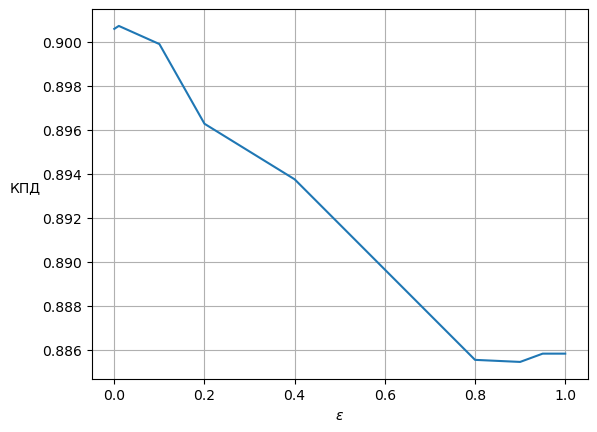

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm

metrics = []
epsilons = [0, 0.01, 0.1, 0.2, 0.4, 0.8, 0.9, 0.95, 1]
for eps in tqdm(epsilons):
    result_matrix, metric = epsilon_greedy_algorithm_one_day_v2(data_path='data/train/day-0.json', epsilon=eps)
    metrics.append(metric)

plt.plot(epsilons, metrics)
plt.xlabel('$\epsilon$')
plt.ylabel(r'КПД', rotation=0, fontsize=10, labelpad=12.0)
plt.grid(True)
plt.show()

### Метрика на всех наборах

In [ ]:
import os
from tqdm import tqdm


folder = 'data/train'
total_metric = 0
for json_name in os.listdir(folder):
    json_path = os.path.join(folder, json_name)
    if os.path.isfile(json_path):
        _, metric = epsilon_greedy_algorithm_one_day_v3(data_path=json_path, epsilon=0.0)
        total_metric += metric
        print(json_name, metric)
print(total_metric / len(os.listdir(folder)))

In [ ]:
# 1. baseline:                                              0.8243
# 2. невостребованные печи по температуре:                  0.83568
# 3. пункт 2 и сначала печи с меньшим количеством операций: 0.8327